# Model Predictive Control Rocket Soft-Landing Problem

This notebook is a walkthough of the ALTRO solver for the MPC Rocket Soft-Landing Problem (i.e. the general control challenge of landing a rocket at rest at a designated landing site). In the simplest case, we treat the rocket as a sphere landing on a flat surface with no atmosphere. This approximation is reasonable when the rocket is near the ground and entering the final part of the descent.

**This files focuses on the MPC problem and comparing the result to other solvers. For the simple (non-MPC) application and set-up explanation, please visit the <code>RocketLandingSOCP-SetupExplained.ipynb</code> file. Thanks!**

In [1]:
using Pkg
Pkg.activate(".\\.")
Pkg.instantiate()

 Activating environment at `C:\Users\Daniel N\.julia\dev\altro-mpc-icra2021\benchmarks\rocket_landing\Project.toml`


## MPC Problem Outline

For the MPC application, we must fulfill two critical steps:
- [x] Solve the optimal trajectory and apply the required controls (usually a short horizon)
- [x] Use the prior trajectory to warm-start the next solve

In this Jupyter notebook, we will:
1. Set up the rocket soft-landing problem
    - Model Dynamics
    - Discretization
    - Specify the Disturbance (e.g. wind) separate from model dynamics
    - Initial and Final States
2. Solve the initial trajectory optimization problem (cold-start)
    - Solve the full trajectory
3. Solve the realtime trajectory optimization problem (warm-start, shorter horizon)
    - Solve the shorter trajectory
    - Execute the control (and propagate forward in time)
    - Warm-Start the next iteration
    - Solve the next shorter horizon trajectory optimization problem
    - Repeat above steps until arrival at the landing location

# Step 1: Set-Up the Rocket Soft-Landing Problem

## Load Required Packages

The <code>RobotDynamics</code> package enables us to define the rocket model and dynamics. The <code>TrajectoryOptimization</code> and <code>Altro</code> set-up and solve the trajectory optimization problem. <code>StaticArrays</code> and <code>LinearAlgebra</code> are required to set-up the appropriate data types.

Next, <code>Plots, MeshCat, TrajOptPlots, FileIO,</code> and <code>MeshIO</code> packages are used to visualize the results. Note that the plotting sections will take significantly longer to run than the optimization. 

Lastly, <code>DifferentialEquations</code> integrates the dynamics forward as a way to show that the dynamics constraints are satisfied.

Loading all the packages, especially for plotting and the differential equations integrator can be the longest part of the whole notebook.

In [2]:
using RobotDynamics
import RobotDynamics: dynamics
using Rotations
using Altro
using TrajectoryOptimization
using StaticArrays, LinearAlgebra
println("Trajectory Optimization Packages Ready")

using Plots
pyplot()
println("Base Plotting Packages Ready")

# using MeshCat, TrajOptPlots
# using FileIO, MeshIO
# println("3D Plotting Packages Ready")

import DifferentialEquations.solve, DifferentialEquations.ODEProblem, DifferentialEquations.Tsit5
using BenchmarkTools
println("Differential Equations Ready")

Trajectory Optimization Packages Ready
Base Plotting Packages Ready
Differential Equations Ready


Add second-order cone constraints

In [3]:
include(".\\src\\general_socp.jl")
println("Added more general SOCP Constraint")

Added more general SOCP Constraint


## Detail the Rocket Dynamics

For the simplified rocket problem, we choose to ignore the attitude dynamics. Applying newton's second law or by forming a Lagrangian, we arrive at the following sparse linear system

$$\frac{dx}{dt} = Ax + Bu + g$$

Where $A = \begin{bmatrix}0 & I\\ 0 & 0 \end{bmatrix}$, $B = \begin{bmatrix}0 \\ \frac{1}{m} I\end{bmatrix}$, and $G = \begin{bmatrix} 0 \\ -g \end{bmatrix}$. For the 3D case, these are $(6 \times 6)$, $(6 \times 3)$, and $(6 \times 1)$ matricies, respectively. 

In [4]:
const mass = 10.0
const grav = SA[0.0; 0.0; -9.81]

model = LinearModel([zeros(3,3) I; zeros(3, 6)], [zeros(3,3); (1/mass) * I], vec([zeros(3, 1); grav]))

struct Rocket
    m
    g
    model
end

## Instantiate the Model and Define the Discretization

Feel free to choose <code>N</code> and <code>tf</code> based on your needs.

In [5]:
rocket = Rocket(mass, grav, model)
n, m = size(rocket.model)

# Trajectory Discretization
N = 301
tf = 10.
dt = tf/(N-1)

rocket # (Simply for information) Display the struct as the cell output 

Rocket(10.0, [0.0, 0.0, -9.81], LinearModel{6,3,Float64,15}(SizedArray{Tuple{6,6},Float64,2,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], SizedArray{Tuple{6,3},Float64,2,2}[[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.1 0.0; 0.0 0.0 0.1]], SizedArray{Tuple{6},Float64,1,1}[[0.0, 0.0, 0.0, 0.0, 0.0, -9.81]], Float64[], 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true))

## Detail the Full Dynamics (With Distrubance)

In Matlab, we would use ODE 45, but in the <code>DifferentialEquations.jl</code> package we can either (1) just let the <code>solve</code> method figure it out or (2) specify a solver such as <code>Tsit5</code>, which should handle any ODE that a fourth-order Runge Kutta Method could handle.

In [6]:
"Disturbance"
function wind(y, p, t)
    return [zeros(3); 0; 0.5; 0]
end

"Disturbance"
function no_wind(y, p, t)
    return zeros(6)
end

"Full Dynamics Model"
function full_model(r::Rocket, x0, dt::Float64, controlsArr, disturbance; num_timesteps::Int64 = 3, t0::Float64 = 0.0)
    # Zero-Order Hold
    get_controls(t) = controlsArr[min(Int(floor(t/dt)) + 1, size(controlsArr,1))]
    # Full Dynamics
    f(y,p,t) = dynamics(r.model, y, get_controls(t)) + disturbance(y, p, t)

    tspan = (t0, t0 + dt * num_timesteps)
    controls_p0 = get_controls(t0)

    # Use the DifferentialEquations.jl Package
    ode_prob = ODEProblem(f, x0, tspan, controls_p0)
    ode_sol = solve(ode_prob, Tsit5(), reltol=1e-10, abstol=1e-10);
    
    return ode_sol
end

full_model

## Specify the Initial and Final Conditions

Choose the initial and final points. Note that these must be full state vectors ($[x; y; z; v_x; v_y; v_z]$). The initial point is generally the rocket's current state. The final point is generally the rocket's landing stop. Note that the final velocity of the rocket should **always** be $[0.0; 0.0; 0.0]$ to have a **soft** landing.

In [7]:
# Initial and Final Conditions
rocketStart = @SVector [4.0, 2.0, 20.0, -3.0, 2.0, -5.0] # Start at a 20 m altitude with an ~15 m/s plummet
rocketEnd = @SVector zeros(n);  # Swing pendulum up and end at rest

# Step 2: Solve Cold Start Trajectory

In [8]:
# Helper function for Max Thrust Constraint
function getAlpha(theta, deg = true)
    if deg
        return tand(theta)
    end
    return tan(theta)
end

#=
Solve the trajectory optimization problem from current location to the final landing spot.

Returns the benchmark data and the optimized solve
=#
function ColdStartFull(r::Rocket, x0, xf, N, opts; 
                        Qk::Float64 = 1.0e-2, Qfk::Float64 = 100.0, Rk::Float64 = 1.0e-1, 
                        ground_level::Float64 = 0.0, theta_max_deg::Float64 = 7.0, perWeightMax::Float64 = 2.0,
                        includeGoal::Bool = true, verbose::Bool = true)
    n, m = size(r.model)
    
    # Set-UP the LQR Objective Function
    Q = Qk * Diagonal(@SVector ones(n))
    Qf = Qfk * Diagonal(@SVector ones(n))
    R = Rk * Diagonal(@SVector ones(m))
    obj = LQRObjective(Q,R,Qf,xf,N)
    if verbose
        println("Objective Set")
    end
    
    # Create Empty ConstraintList
    conSet = ConstraintList(n,m,N)
    
    if includeGoal
        # Goal Constraint that the rocket must reach the landing site.
        goal = GoalConstraint(xf)
        add_constraint!(conSet, goal, N)
        if verbose
            println("Goal Constraint Set")
        end
    end
    
    # Bound Constraint that the rocket doesn't crash into the ground
    # This constraint can be made more complicated for difficult terrain
    # This constraint can also be a glidescope constraint.
    bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                      -Inf, -Inf, -Inf])
    if verbose
        println("Ground Constraint Set")
    end
    
    # Norm Constrant that reflects the max thrust the rocket can provide
    u_bnd = r.m * norm(r.g[3]) * perWeightMax
    maxT = NormConstraint(n, m, u_bnd, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxT, 1:N-1)
    if verbose
        println("Max Thrust Constraint Set")
    end

    # Generalized Norm Constraint that reflects the max thrust angle constraint
    # Based on the rocket gimbal
    maxTAalpha = getAlpha(theta_max_deg)
    ARocket = SizedMatrix{3,3}([1.0 0 0; 0 1.0 0; 0 0 0])
    cRocket = SVector{3}([0; 0; maxTAalpha])
    maxTA = NormConstraint2(n, m, ARocket, cRocket, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxTA, 1:N-1)
    if verbose
        println("Max Thrust Angle Constraint Set")
    end
    
    # Package the objective and constraints into a "problem" type
    prob = Problem(r.model, obj, xf, tf, x0=x0, constraints=conSet)
    if verbose
        println("Problem Packaged")
    end
    
    # Set the initial controls to a hover
    u0 = r.g # controls that would nominally hover
    U0 = [u0 for k = 1:N-1] # vector of the small controls
    initial_controls!(prob, U0)
    rollout!(prob)
    if verbose
        println("Set Initial Controls")
    end
    
    altro = ALTROSolver(prob, opts)
    if verbose
        println("Set Solver and Options")
    end
    
    println("Prepping benchmark solve")
    set_options!(altro, show_summary=false)
    b = benchmark_solve!(altro)
    println("Benchmark solve")
    
    println("Prepping solve with summary")
    set_options!(altro, show_summary=true)
    solve!(altro);
    println("Solve Complete")
    
    return b, altro
end

ColdStartFull (generic function with 1 method)

In [9]:
opts = SolverOptions(
        cost_tolerance_intermediate=1e-2,
        penalty_scaling=10.,
        penalty_initial=1.0,
        verbose = 1,
        projected_newton = false,
        constraint_tolerance = 1.0e-8
    )

b, altro_solve = ColdStartFull(rocket, rocketStart, rocketEnd, N, opts)

X_cold = states(altro_solve)
U_cold = controls(altro_solve)
Z_cold = get_trajectory(altro_solve);

Objective Set
Goal Constraint Set
Ground Constraint Set
Max Thrust Constraint Set
Max Thrust Angle Constraint Set
Problem Packaged
Set Initial Controls
Set Solver and Options
Prepping benchmark solve
Benchmark solve
Prepping solve with summary

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 16
    Solve Time: 49.4895 (ms)

  Covergence
    Terminal Cost: 5343.071712797593
    Terminal dJ: 0.3446846858423669
    Terminal gradient: 2.851677900167831e-6
    Terminal constraint violation: 4.6514750384751835e-11
    Solve Status: SOLVE_SUCCEEDED
Solve Complete


In [10]:
b

BenchmarkTools.Trial: 
  memory estimate:  64.29 MiB
  allocs estimate:  552349
  --------------
  minimum time:     50.940 ms (11.20% GC)
  median time:      52.506 ms (11.06% GC)
  mean time:        52.448 ms (11.51% GC)
  maximum time:     53.532 ms (12.56% GC)
  --------------
  samples:          10
  evals/sample:     10

### Visualize the Reference Trajectory

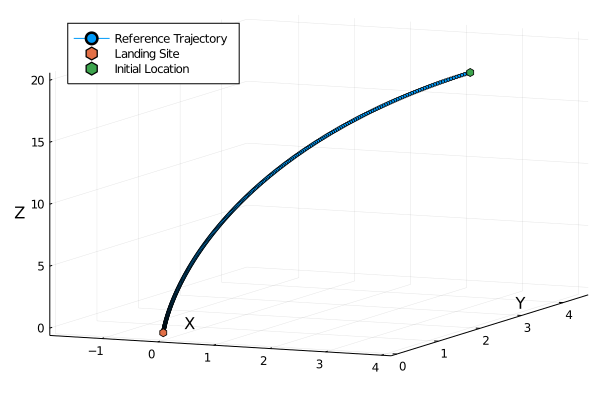

In [11]:
function get_arr_at_ind(arr, ind)
    return [x[ind] for x in arr]
end

gr()
plot3d(get_arr_at_ind(X_cold, 1), get_arr_at_ind(X_cold, 2), get_arr_at_ind(X_cold, 3), 
    markershape = :circle, markersize = 2, label = "Reference Trajectory", xlabel = "X", ylabel = "Y", zlabel = "Z",
    legend = :topleft)
scatter!([rocketEnd[1]], [rocketEnd[2]], [rocketEnd[3]], markershape = :hexagon, label = "Landing Site")
scatter!([rocketStart[1]], [rocketStart[2]], [rocketStart[3]], markershape = :hexagon, label = "Initial Location")

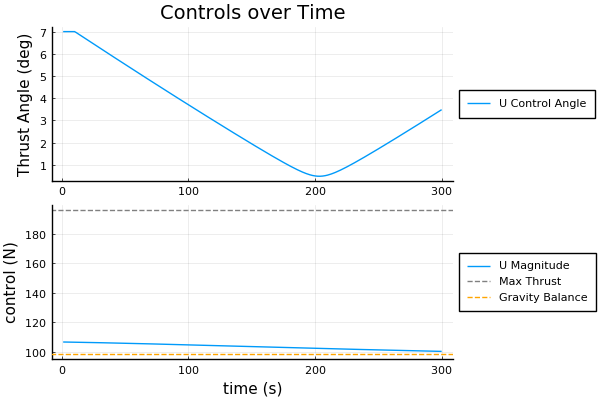

In [12]:
function getAngle3D(u)
    if norm(u[3]) == 0.0
        # hit the tan singularity
        return 0.0
    else
        return atand(norm([u[1]; u[2]]), u[3])
    end
end

function get_angle_xy(u)
    return atand(u[2], u[1])
end

pyplot()

plt_ux = plot(getAngle3D.(U_cold), label = "U Control Angle", legend = :outerright)
# hline!([-ulateral_max, ulateral_max], linecolor = :grey, linestyle = :dash,
#                 label = "Max Lateral Thrust")
# xlabel!("time (s)")
ylabel!("Thrust Angle (deg)")
title!("Controls over Time")

plt_umag = plot(norm.(U_cold), label = "U Magnitude", legend = :outerright)
hline!([2 * norm(mass * grav[3])], linecolor = :grey, linestyle = :dash, label = "Max Thrust")
hline!([norm(mass * grav[3])], linecolor = :orange, linestyle = :dash, label = "Gravity Balance")
xlabel!("time (s)")
ylabel!("control (N)")

plt_u = plot(plt_ux, plt_umag, layout = (2, 1))

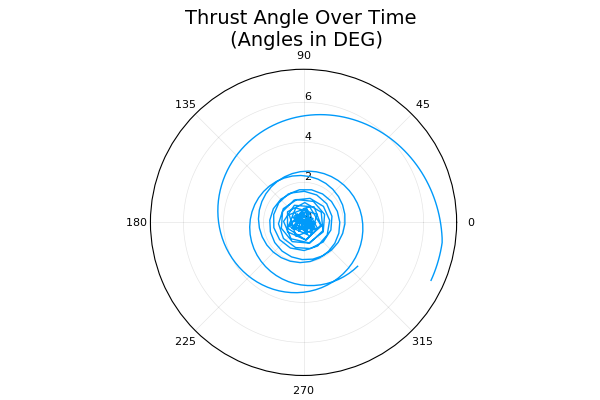

In [13]:
theta = get_angle_xy.(U_cold)
rad = getAngle3D.(U_cold)

plot(theta, rad, proj = :polar, legend = :none, title = "Thrust Angle Over Time \n (Angles in DEG)")

# Step 3: Solve Warm-Start and Model the Rocket Descent

In [14]:
mutable struct MPC
    p::Problem         # Stores the problem struct
    x_curr             # Current state
    X_reference        # Reference states of trajectory calculated above
    U_reference        # Reference controls of trajectory calculated above
    k_curr::Int64      # Current index of the reference trajectory
end

In [15]:
#=
Solve the trajectory optimization problem from current location to the final landing spot.

Returns the benchmark data and the optimized solve
=#
function MPC_SetUp(r::Rocket, x_ref, u_ref, horizon, tf; 
                        Qk::Float64 = 1.0e-2, Qfk::Float64 = 100.0, Rk::Float64 = 1.0e-1, 
                        ground_level::Float64 = 0.0, theta_max_deg::Float64 = 8.0, 
                        perWeightMax::Float64 = 2.0, verbose::Bool = true)
    
    @assert length(x_ref) >= horizon
    @assert length(u_ref) >= horizon - 1
    
    xTrack = x_ref[1:horizon]
    uTrack = u_ref[1:(horizon - 1)]
    
    n, m = size(r.model)
    println("n = $n, m = $m")
    
    # Set the Objective
    cost_list = TrajectoryOptimization.CostFunction[]
    
    # Set-UP the LQR Tracking Objective Function
    Q = Qk * Diagonal(@SVector ones(n))
    Qf = Qfk * Diagonal(@SVector ones(n))
    R = Rk * Diagonal(@SVector ones(m))
    
    for k in 1:horizon-1
        xf = xTrack[k]
        uf = uTrack[k]
        push!(cost_list, LQRCost(Q, R, xf, uf))
    end
    
    xf = xTrack[end]
    qf = -Qf*xf
    cf = 0.5*xf'*Qf*xf
    push!(cost_list, QuadraticCost(Qf, zeros(0,0),zeros(0,size(Qf,1)), qf, zeros(0), cf, terminal = true))
    
    obj = Objective(cost_list)
    
    if verbose
        println("Objective Set")
    end
    
    # Create Empty ConstraintList
    conSet = ConstraintList(n, m, horizon)
    
    # Bound Constraint that the rocket doesn't crash into the ground
    # This constraint can be made more complicated for difficult terrain
    # This constraint can also be a glidescope constraint.
    bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                      -Inf, -Inf, -Inf])
    if verbose
        println("Ground Constraint Set")
    end
    
    # Norm Constrant that reflects the max thrust the rocket can provide
    u_bnd = r.m * norm(r.g[3]) * perWeightMax
    maxT = NormConstraint(n, m, u_bnd, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxT, 1:horizon-1)
    if verbose
        println("Max Thrust Constraint Set")
    end

    # Generalized Norm Constraint that reflects the max thrust angle constraint
    # Based on the rocket gimbal
    maxTAalpha = getAlpha(theta_max_deg)
    ARocket = SizedMatrix{3,3}([1.0 0 0; 0 1.0 0; 0 0 0])
    cRocket = SVector{3}([0; 0; maxTAalpha])
    maxTA = NormConstraint2(n, m, ARocket, cRocket, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxTA, 1:horizon-1)
    if verbose
        println("Max Thrust Angle Constraint Set")
    end
    
    # Goal Constraint that the rocket must reach the landing site.
    goal = GoalConstraint(xTrack[end])
    add_constraint!(conSet, goal, horizon)
    if verbose
        println("Goal Constraint Set at $xf")
    end
    
    # Package the objective and constraints into a "problem" type
    prob = Problem(r.model, obj, xf, tf, x0=xTrack[1], constraints=conSet)
    if verbose
        println("Problem Packaged with \nxf = $xf, \nx0 = $(prob.x0), \ntf = $tf")
    end
    
    initial_controls!(prob, uTrack)
    initial_states!(prob, xTrack)
    rollout!(prob)
    
    return MPC(prob, xTrack[1], x_ref, u_ref, 1)
end

MPC_SetUp (generic function with 1 method)

In [16]:
function update_MPC_controller!(mpc::MPC, k_new; verbose::Bool = false)
    
    hor = mpc.p.N
    
    TrajectoryOptimization.set_initial_state!(mpc.p, mpc.x_curr)
    
    X_warm = [[mpc.x_curr]; mpc.X_reference[k_new + 1:k_new + 1 + hor]]
    
    if verbose
        println("Updated Initial State")
    end
    
    # Update the Reference Trajectory
    for k in 1:(hor - 1)
        TrajectoryOptimization.set_LQR_goal!(mpc.p.obj.cost[k], X_warm[k], mpc.U_reference[k + k_new - 1])
    end
    TrajectoryOptimization.set_LQR_goal!(mpc.p.obj.cost[end], X_warm[end])
    
    if verbose
        println("Updated LQR")
    end
    
    # Update the Goal Constraint
    TrajectoryOptimization.set_goal_state!(mpc.p.constraints.constraints[end], X_warm[end])
    
    if verbose
        println("Updated Goal")
    end
    
    initial_controls!(mpc.p, mpc.U_reference[k_new:k_new + hor])
    initial_states!(mpc.p, X_warm)
    
    if verbose
        println("Warm Start Set")
    end
    
    rollout!(mpc.p)
    
    mpc.k_curr = k_new
    
    return nothing
end

function update_MPC_controller!(mpc::MPC, k_new, x_new)
    mpc.x_curr = x_new
    update_MPC_controller!(mpc, k_new)
end

function run_MPC_controller!(mpc::MPC, opts_mpc; verbose::Bool = true)
    altro_mpc = ALTROSolver(mpc.p, opts_mpc)
    set_options!(altro_mpc, show_summary=false)
    solve!(altro_mpc)
    
    vio = max_violation(altro_mpc)
    
    if verbose
        println(vio)
    end

    # Grab the new optimized trajectory
    X_new = states(altro_mpc)
    U_new = controls(altro_mpc)
    
    return X_new, U_new, vio
    
end

function loop_MPC_controller!(mpc::MPC, x_curr, u_curr, dt; 
                                t_curr::Float64 = 0.0, num_tsteps::Int64 = 1, hor::Int64 = 20, 
                                x_threshold::Float64 = 0.002, max_vio::Float64 = 1.0,
                                verbose::Bool = false)
    t_iter = dt * hor
    MPC_Iteration_States = []
    MPC_Iteration_Controls = []
    
    for iter in 1:(N - hor - 1)
        # Step 1: Run the MPC
        if norm(x_curr - X_cold[iter]) > x_threshold
            # Solve MPC Trajectory
            X_mpc_new, U_mpc_new, vio = run_MPC_controller!(mpc, opts, verbose = false)

            if vio > max_vio
                # Constraint is too high
                X_mpc_new = X_cold[iter:iter + hor]
                U_mpc_new = U_cold[iter:iter + hor - 1]
                
                if verbose
                    println("Solve Failed")
                end
            end
        else
            # Use the reference trajectory
            X_mpc_new = X_cold[iter:iter + hor]
            U_mpc_new = U_cold[iter:iter + hor - 1]
            
            if verbose
                println("Reference Trajectory is Applicable")
            end
        end

        # Step 2: Save the Current Controls
        u_curr = U_mpc_new[1]
        push!(MPC_Iteration_Controls, u_curr)

        # Step 3: Propogate the dynamics
        updated_model = full_model(rocket, x_curr, dt, [u_curr], wind, num_timesteps = num_tsteps, t0 = t_curr)

        # Step 4: Save the Current State
        t_curr = updated_model.t[end]
        x_curr = updated_model.u[end]
        push!(MPC_Iteration_States, x_curr)

        # Step 5: Update the MPC for the next iteration
        update_MPC_controller!(mpc, iter, x_curr)
        
        if verbose
            println("At Iteration $iter @ $(norm(x_curr - X_cold[iter + 1]))")
        end
    end
    
    return MPC_Iteration_States, MPC_Iteration_Controls
end

loop_MPC_controller! (generic function with 1 method)

Execute the MPC forward until landed

In [17]:
# Initial Conditions
x_curr = rocketStart   # Current state (x, v)
u_curr = [U_cold[1]]   # Controls (u) applied at this instant
hor = 20               # length of the MPC horizon in number of steps
t_iter = dt * hor      # Time to end of horizon

# Default Conditions
# t_curr = 0.0           # Start time
# num_tsteps = 1         # Number of steps to propogate the physics
# x_threshold = 0.002      # ||x_curr - X_cold[k]|| ≤ x_threshold -> You can just use the reference trajectory


##############################################

benchmark_arr = []

opts = SolverOptions(
        cost_tolerance_intermediate=1e-2,
        penalty_scaling=10.,
        penalty_initial=10.0,
        projected_newton = false
    )

##############################################

mpc = MPC_SetUp(rocket, X_cold, U_cold, hor, t_iter, verbose = false)
@assert length(mpc.X_reference) == length(X_cold)


# This will take 500s (~8 minutes) to run
b = @benchmark loop_MPC_controller!(mpc, x_curr, u_curr, dt) samples=10 evals=10 seconds=500

# Save one iteration
MPC_Iteration_States, MPC_Iteration_Controls = loop_MPC_controller!(mpc, x_curr, u_curr, dt);

n = 6, m = 3


In [18]:
println("Each iteration has $(N - hor - 1) MPC Steps (which includes propgating the physics)")
println("Hence, we have a median $(median(b).time / ((N - hor - 1) * 1e6) ) ms per MPC iteration")

b

Each iteration has 280 MPC Steps (which includes propgating the physics)
Hence, we have a median 49.931387249821434 ms per MPC iteration


BenchmarkTools.Trial: 
  memory estimate:  16.46 GiB
  allocs estimate:  275819189
  --------------
  minimum time:     13.365 s (11.93% GC)
  median time:      13.981 s (11.46% GC)
  mean time:        13.925 s (11.54% GC)
  maximum time:     14.373 s (11.36% GC)
  --------------
  samples:          4
  evals/sample:     10

In [19]:
BenchmarkTools.save("Rocket_MPC_SOCP_Altro.json", b)

## Lastly, let's visualize the results in 3D with Plots and Meshcat

To do this, we need to provide a Mesh to <code>MeshCat</code>. This is due with <code>FileIO</code> and <code>MeshIO</code>.

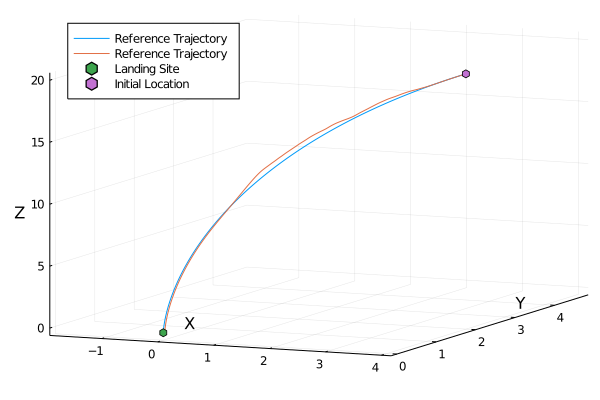

In [20]:
function get_arr_at_ind(arr, ind)
    return [x[ind] for x in arr]
end

gr()
plot3d(get_arr_at_ind(X_cold, 1), get_arr_at_ind(X_cold, 2), get_arr_at_ind(X_cold, 3), 
    label = "Reference Trajectory", xlabel = "X", ylabel = "Y", zlabel = "Z", legend = :topleft)
plot3d!(get_arr_at_ind(MPC_Iteration_States, 1), get_arr_at_ind(MPC_Iteration_States, 2), 
    get_arr_at_ind(MPC_Iteration_States, 3), 
    label = "Reference Trajectory", xlabel = "X", ylabel = "Y", zlabel = "Z", legend = :topleft)
scatter!([rocketEnd[1]], [rocketEnd[2]], [rocketEnd[3]], markershape = :hexagon, label = "Landing Site")
scatter!([rocketStart[1]], [rocketStart[2]], [rocketStart[3]], markershape = :hexagon, label = "Initial Location")

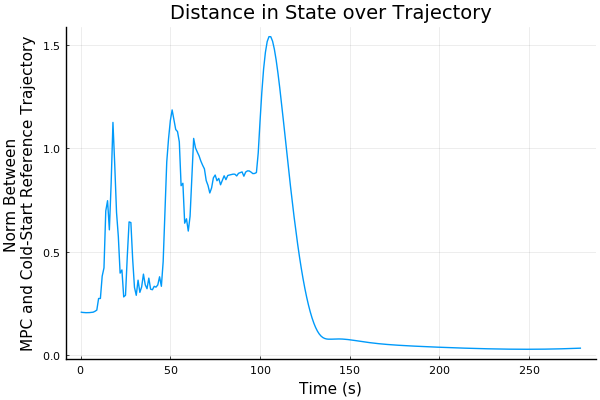

In [21]:
pyplot()

timeVec = dt .* 1:N
timeVecTrunc = timeVec[1:length(MPC_Iteration_States)]

plot(timeVecTrunc, norm.(X_cold[1:length(MPC_Iteration_States)] - MPC_Iteration_States), legend = :none)
xlabel!("Time (s)")
ylabel!("Norm Between \nMPC and Cold-Start Reference Trajectory")
title!("Distance in State over Trajectory")

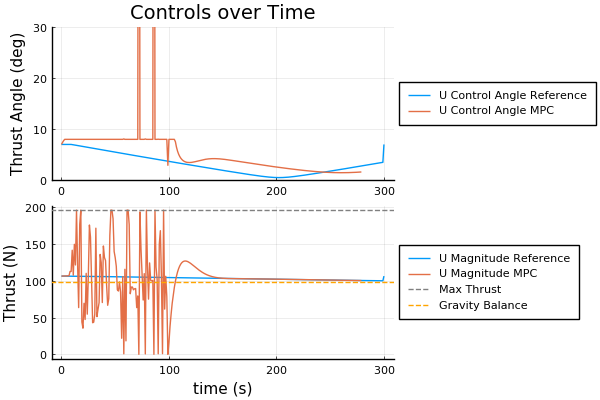

In [22]:
pyplot()

plt_ux = plot(timeVec, getAngle3D.(U_cold), label = "U Control Angle Reference", legend = :outerright)
plot!(timeVecTrunc, getAngle3D.(MPC_Iteration_Controls), label = "U Control Angle MPC")
# xlabel!("time (s)")
ylabel!("Thrust Angle (deg)")
title!("Controls over Time")
ylims!(0, 30)

plt_umag = plot(timeVec, norm.(U_cold), label = "U Magnitude Reference", legend = :outerright)
plot!(timeVecTrunc, norm.(MPC_Iteration_Controls), label = "U Magnitude MPC", legend = :outerright)
hline!([2 * norm(mass * grav[3])], linecolor = :grey, linestyle = :dash, label = "Max Thrust")
hline!([norm(mass * grav[3])], linecolor = :orange, linestyle = :dash, label = "Gravity Balance")
xlabel!("time (s)")
ylabel!("Thrust (N)")

plt_u = plot(plt_ux, plt_umag, layout = (2, 1))

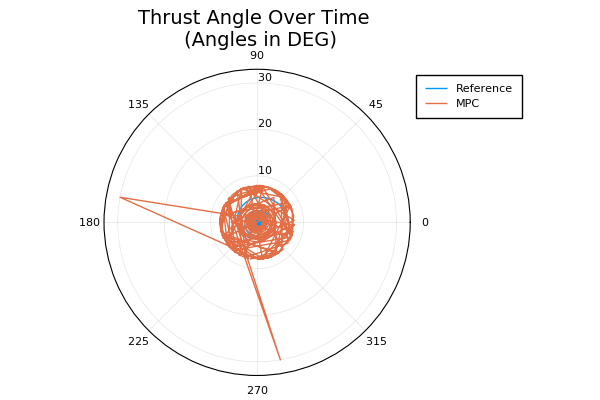

In [23]:
max_angle_radius = 30

plot(get_angle_xy.(U_cold), min.(max_angle_radius * ones(length(U_cold)), getAngle3D.(U_cold)), 
        proj = :polar, label = "Reference", legend = :outertopright, title = "Thrust Angle Over Time \n (Angles in DEG)")
plot!(get_angle_xy.(MPC_Iteration_Controls), 
        min.(max_angle_radius * ones(length(MPC_Iteration_Controls)), getAngle3D.(MPC_Iteration_Controls)), 
        proj = :polar, label = "MPC", title = "Thrust Angle Over Time \n (Angles in DEG)")

In [24]:
# vis = Visualizer() # Creates a MeshCat Window
# render(vis) # Renders the window below

In [25]:
# function TrajOptPlots._set_mesh!(vis, model::Rocket)
#     obj = joinpath(@__DIR__, "SimpleRocket.obj")
#     quad_scaling = 0.085
#     robot_obj = FileIO.load(obj)
#     robot_obj.vertices .*= quad_scaling
#     mat = MeshPhongMaterial(color=colorant"lightgrey")
#     setobject!(vis["geom"], robot_obj, mat)
# end

# TrajOptPlots.set_mesh!(vis, model)

In [26]:
# Base.position(::Rocket, x::StaticVector) = SA[x[1], x[2], x[3]]
# RobotDynamics.orientation(::Rocket, x::StaticVector) = UnitQuaternion(0,0,0,1)

# visualize!(vis, altro);